# Pick out cues from Accelerometer data

Alternative alignment extraction path for multidevice accelerometry recordings. 

Some recordings include only one tapping or clapping cue, some include multiple.

For a single accelerometry recording:

    0. Load accelerometry file, resample and collapse to 1D absolut Jerk. 
    1. Load all relevant template cues and their approximate position.
    2. Automate IDing each synchronisation cue in the  with cross correlations.
    3. Review cue timing
    4. Save the detected timing of each cue IN DEVICE TIMESTAMP VALUES
    
Output timing information is used in a difference script to shift recordings to common concert time.

## libraries and function files

In [4]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [5]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%reload_ext autoreload

# cue and concert details

In [7]:
all_cues ={'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.919+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:00.040+0000'),# -2.46
              'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.324+0000'),
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.246+0000'),#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000'),
              'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:26.888000+00:00'),#'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:20.769000+00:00'),#'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00'),
              'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00')}
c_types = {'RE_Synch':'taps',
                'RD_Reic': 'claps',
                'RD_Synch':'taps',
                'RD_Reic2':'claps',
                'C1_Reic':'claps',#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                'C2_Reic':'claps', # 97.0 
                'C1_Synch':'taps',
                'C2_Synch':'taps',
                'C3_Synch':'taps',
                'C3_Reic': 'claps',
                'C4_Synch':'taps',
                'C4_Reic': 'claps',
                'C5_Synch':'taps',
                'C5_Reic': 'claps',} 
cue_files ={'RE_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic': './Timing/RD_Reic1.csv',
               'RD_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic2':'./Timing/RD_Reic2.csv',
            'C1_Synch':'./Timing/short_taps.csv',
               'C1_Reic': './Timing/C1_reic_claps.csv',
               'C2_Synch':'./Timing/short_taps.csv',
               'C2_Reic':'./Timing/C2_reic_claps.csv',
           'C3_Synch':'./Timing/short_taps.csv',
               'C3_Reic': './Timing/C3_reic_claps.csv',
               'C4_Synch':'./Timing/short_taps.csv',
               'C4_Reic':'./Timing/C4_reic_claps.csv',
            'C5_Synch':'./Timing/short_taps.csv',
               'C5_Reic': './Timing/C5_claps.csv',} 
concert_cues = {'RG':[], 'RE':['RE_Synch'], 'RD':['RD_Synch',
 'RD_Reic',], 'C1':['C1_Synch',
 'C1_Reic'], 'C2':['C2_Synch',
 'C2_Reic',], 'C3':['C3_Synch',
 'C3_Reic'], 'C4':['C4_Synch',
 'C4_Reic',], 'C5':['C5_Synch',
 'C5_Reic']}
cue_concerts = ['RE', 'RD','RD','RD', 'C1', 'C1', 'C2','C2', 'C3', 'C3', 'C4','C4', 'C5', 'C5']

cue_dets = pd.DataFrame(index = all_cues.keys())
cue_dets['Cue_concert'] = cue_concerts
cue_dets['Cue_datetime'] = pd.Series(all_cues)
cue_dets['Cue_type'] = pd.Series(c_types)
cue_dets['Cue_files'] = pd.Series(cue_files)
cue_dets.to_csv('./Timing/cue_details.csv')

In [8]:
cue_dets = pd.read_csv('./Timing/cue_details.csv',index_col = 0)
cue_dets['Cue_datetime'] = pd.to_datetime(cue_dets['Cue_datetime'])
cue_time_map=pd.read_csv('./Timing/cue_times_mapping.csv',index_col = 0)
cue_dets['cTime_s'] = cue_time_map['cTime_s']
cue_dets

,Cue_concert,Cue_datetime,Cue_type,Cue_files,cTime_s
RE_Synch,RE,2023-02-15 10:25:26.573000+00:00,taps,./Timing/synch_cue_taps.csv,0.000
RD_Synch,RD,2023-02-15 11:05:36.897000+00:00,taps,./Timing/synch_cue_taps.csv,0.000
RD_Reic,RD,2023-02-15 11:16:50.919000+00:00,claps,./Timing/RD_Reic1.csv,674.022
RD_Reic2,RD,2023-02-15 12:02:00.040000+00:00,claps,./Timing/RD_Reic2.csv,3383.143
C1_Synch,C1,2023-02-16 08:33:18.324000+00:00,taps,./Timing/short_taps.csv,0.000
C1_Reic,C1,2023-02-16 08:45:22.246000+00:00,claps,./Timing/C1_reic_claps.csv,723.922
C2_Synch,C2,2023-02-16 10:16:22.697000+00:00,taps,./Timing/short_taps.csv,0.000
C2_Reic,C2,2023-02-16 10:27:10.927000+00:00,claps,./Timing/C2_reic_claps.csv,648.230
C3_Synch,C3,2023-02-17 08:30:51.841000+00:00,taps,./Timing/short_taps.csv,0.000
C3_Reic,C3,2023-02-17 08:40:31.007000+00:00,claps,./Timing/C3_reic_claps.csv,579.166


In [9]:
Show_folder = {
    'RG':'../Data/AlignedPhys/20230215_RG/Full/',
    'RE':'../Data/AlignedPhys/20230215_RE/Full/',
    'RD':'../Data/AlignedPhys/20230215_RD/Full/',
    'C1':'../Data/AlignedPhys/20230216_C1/Full/',
    'C2':'../Data/AlignedPhys/20230216_C2/Full/',
    'C3':'../Data/AlignedPhys/20230217_C3/Full/',
    'C4':'../Data/AlignedPhys/20230217_C4/Full/',
    'C5':'../Data/AlignedPhys/20230218_C5/Full/'}
eq_sigs = {'RR':'MSCIBI','FASTACC':'MSBACC','ECG':'MS1ECG'}

In [10]:
#Piece_timings, Piece_dt
Show_intervals = {
    'RG':[pd.to_datetime('2023-02-15 09:00:00.000+0000'),pd.to_datetime('2023-02-15 10:15:00.000+0000')],
    'RE':[pd.to_datetime('2023-02-15 10:13:00.000+0000'),pd.to_datetime('2023-02-15 10:28:00.000+0000')],
    'RD':[pd.to_datetime('2023-02-15 11:05:21.897+0000'),pd.to_datetime('2023-02-15 12:02:27.591+0000')],
    'C1':[pd.to_datetime('2023-02-16 08:33:03.524+0000'),pd.to_datetime('2023-02-16 09:36:09.960+0000')],
    'C2':[pd.to_datetime('2023-02-16 10:16:07.697+0000'),pd.to_datetime('2023-02-16 11:15:33.567+0000')],
    'C3':[pd.to_datetime('2023-02-17 08:30:36.841+0000'),pd.to_datetime('2023-02-17 09:30:11.399+0000')],
    'C4':[pd.to_datetime('2023-02-17 10:16:11.888+0000'),pd.to_datetime('2023-02-17 11:15:14.883+0000')],
    'C5':[pd.to_datetime('2023-02-18 15:10:14.583+0000'),pd.to_datetime('2023-02-18 16:10:47.401+0000')]}
Show_syncs = {
    'RG':pd.to_datetime('2023-02-15 09:00:00.000+0000'),
    'RE':pd.to_datetime('2023-02-15 10:13:00.000+0000'),
    'RD':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
    'C1':pd.to_datetime('2023-02-16 08:33:18.524+0000'),
    'C2':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
    'C3':pd.to_datetime('2023-02-17 08:30:51.841+0000'),
    'C4':pd.to_datetime('2023-02-17 10:16:26.888+0000'),
    'C5':pd.to_datetime('2023-02-18 15:10:29.583+0000')}

In [11]:
Piece_timings = pd.read_csv('./Timing/Concerttimes_DateTimeUTC.csv', index_col = 0)


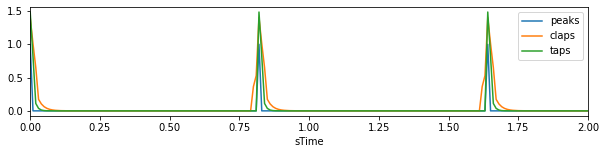

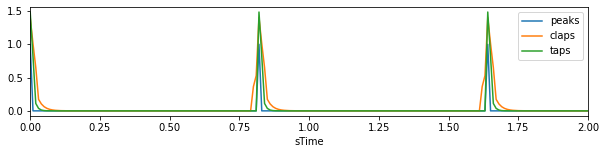

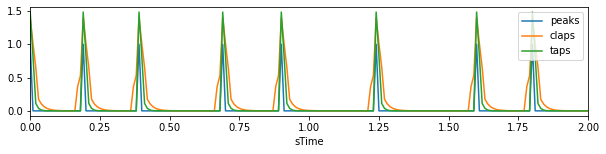

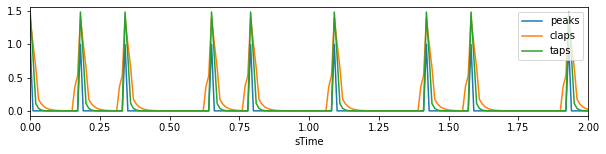

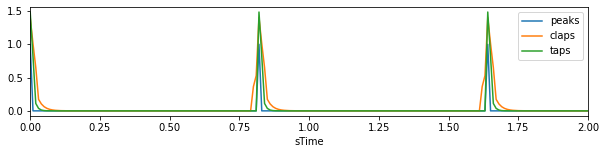

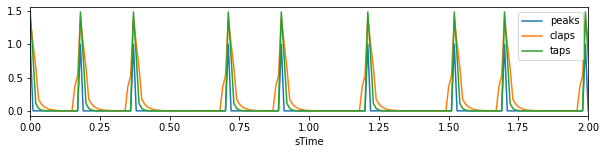

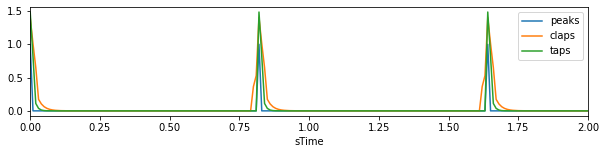

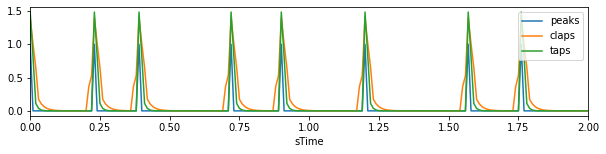

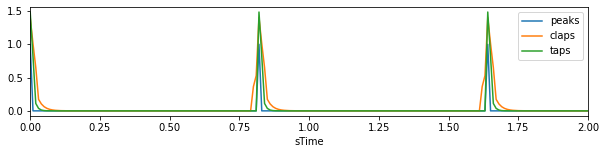

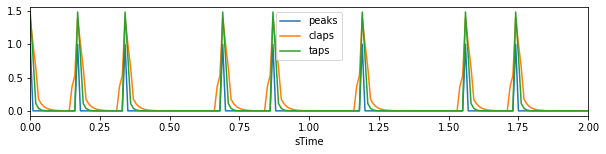

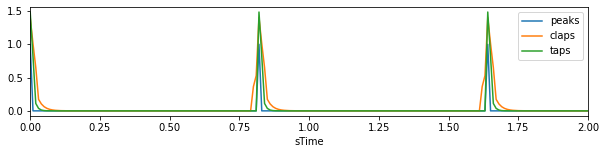

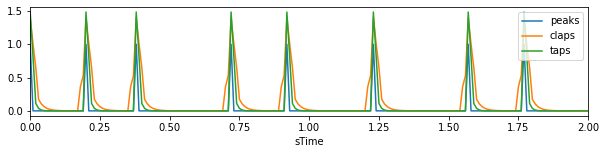

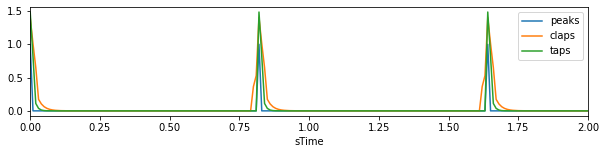

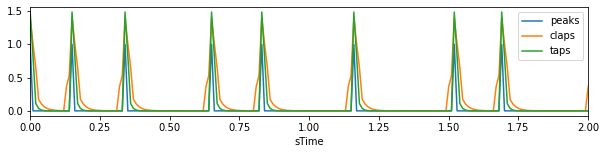

In [12]:
CueT={} # list of cues to check
# sample rate for comparison between cue template and signal
sf = 100
t_range= [-10,20]
for c in all_cues.keys():
    cue_times = pd.read_csv(cue_files[c],",",header=None)
    if len(cue_times.columns)>3:
        cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
        cue_times['event'] = cue_times[1]
        cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
        peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']
    else:
        peak_times = list(cue_times[0]-cue_times.loc[0,0])
    
    cue = al.cue_template_make(peak_times,sf,t_range)

    cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[10,2])
    plt.xlim([0,2])
    plt.show()
    CueT[c] = cue 

# Sensor Recording Metadata

In [14]:
data_loc = '../Data/Movesense/EqForm_new/'
files = os.listdir(data_loc)
# check timing feild
V = pd.read_csv(data_loc + files[2])
V['DateTime'] = pd.to_datetime(V['DateTime'])
V.loc[len(V)-1,'DateTime']

Timestamp('2023-02-15 11:54:18.828000+0000', tz='UTC')

In [15]:
ms_files= pd.read_csv('ms_eql_log.csv',index_col = 0).reset_index(drop=True)
ms_files['Date'] = pd.to_datetime(ms_files['Date'])
ms_files['RecStart'] = pd.to_datetime(ms_files['RecStart'])
ms_files['RecEnd'] = pd.to_datetime(ms_files['RecEnd'])
ms_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,ECG,577,PC706,2023-02-15 10:58:31,RD,ECG-PC706-577-230215105831.csv,csv,63427634,2023-02-15 10:58:31.276000+00:00,2023-02-15 11:54:20+00:00,3348.724,../Data/Movesense/EqForm_new/ECG-PC706-577-230...
1,RR,577,PC706,2023-02-15 10:58:31,RD,RR-PC706-577-230215105831.csv,csv,128112,2023-02-15 11:06:43.782000+00:00,2023-02-15 11:54:18.828000+00:00,2855.046,../Data/Movesense/EqForm_new/RR-PC706-577-2302...
2,FASTACC,577,PC706,2023-02-15 10:58:31,RD,FASTACC-PC706-577-230215105831.csv,csv,61797344,2023-02-15 10:58:31.365000+00:00,2023-02-15 11:54:20+00:00,3348.635,../Data/Movesense/EqForm_new/FASTACC-PC706-577...
3,ECG,587,PC706,2023-02-16 07:42:49,C1,ECG-PC706-587-230216074249.csv,csv,95768710,2023-02-16 07:42:49.178000+00:00,2023-02-16 09:07:12+00:00,5062.822,../Data/Movesense/EqForm_new/ECG-PC706-587-230...
4,RR,587,PC706,2023-02-16 07:42:49,C1,RR-PC706-587-230216074249.csv,csv,233767,2023-02-16 07:56:09.430000+00:00,2023-02-16 09:07:10.964000+00:00,4261.534,../Data/Movesense/EqForm_new/RR-PC706-587-2302...
5,FASTACC,587,PC706,2023-02-16 07:42:49,C1,FASTACC-PC706-587-230216074249.csv,csv,93032955,2023-02-16 07:42:49.158000+00:00,2023-02-16 09:07:12+00:00,5062.842,../Data/Movesense/EqForm_new/FASTACC-PC706-587...
6,FASTACC,596,PC708,2023-02-16 07:52:46,C1,FASTACC-PC708-596-230216075246.csv,csv,93130993,2023-02-16 07:52:46.072000+00:00,2023-02-16 09:15:46+00:00,4979.928,../Data/Movesense/EqForm_new/FASTACC-PC708-596...
7,RR,596,PC708,2023-02-16 07:52:46,C1,RR-PC708-596-230216075246.csv,csv,291201,2023-02-16 07:58:06.380000+00:00,2023-02-16 09:15:45.108000+00:00,4658.728,../Data/Movesense/EqForm_new/RR-PC708-596-2302...
8,ECG,596,PC708,2023-02-16 07:52:46,C1,ECG-PC708-596-230216075246.csv,csv,94317106,2023-02-16 07:52:46.050000+00:00,2023-02-16 09:15:46+00:00,4979.950,../Data/Movesense/EqForm_new/ECG-PC708-596-230...
9,FASTACC,596,PC708,2023-02-16 09:33:34,C2,FASTACC-PC708-596-230216093334.csv,csv,90450677,2023-02-16 09:33:34.998000+00:00,2023-02-16 10:54:28+00:00,4853.002,../Data/Movesense/EqForm_new/FASTACC-PC708-596...


# TEST Load an acceleration file
Check the code to extract movement information from these recordings.

In [16]:
df_files = ms_files.reset_index(drop=True)
df_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,ECG,577,PC706,2023-02-15 10:58:31,RD,ECG-PC706-577-230215105831.csv,csv,63427634,2023-02-15 10:58:31.276000+00:00,2023-02-15 11:54:20+00:00,3348.724,../Data/Movesense/EqForm_new/ECG-PC706-577-230...
1,RR,577,PC706,2023-02-15 10:58:31,RD,RR-PC706-577-230215105831.csv,csv,128112,2023-02-15 11:06:43.782000+00:00,2023-02-15 11:54:18.828000+00:00,2855.046,../Data/Movesense/EqForm_new/RR-PC706-577-2302...
2,FASTACC,577,PC706,2023-02-15 10:58:31,RD,FASTACC-PC706-577-230215105831.csv,csv,61797344,2023-02-15 10:58:31.365000+00:00,2023-02-15 11:54:20+00:00,3348.635,../Data/Movesense/EqForm_new/FASTACC-PC706-577...
3,ECG,587,PC706,2023-02-16 07:42:49,C1,ECG-PC706-587-230216074249.csv,csv,95768710,2023-02-16 07:42:49.178000+00:00,2023-02-16 09:07:12+00:00,5062.822,../Data/Movesense/EqForm_new/ECG-PC706-587-230...
4,RR,587,PC706,2023-02-16 07:42:49,C1,RR-PC706-587-230216074249.csv,csv,233767,2023-02-16 07:56:09.430000+00:00,2023-02-16 09:07:10.964000+00:00,4261.534,../Data/Movesense/EqForm_new/RR-PC706-587-2302...
5,FASTACC,587,PC706,2023-02-16 07:42:49,C1,FASTACC-PC706-587-230216074249.csv,csv,93032955,2023-02-16 07:42:49.158000+00:00,2023-02-16 09:07:12+00:00,5062.842,../Data/Movesense/EqForm_new/FASTACC-PC706-587...
6,FASTACC,596,PC708,2023-02-16 07:52:46,C1,FASTACC-PC708-596-230216075246.csv,csv,93130993,2023-02-16 07:52:46.072000+00:00,2023-02-16 09:15:46+00:00,4979.928,../Data/Movesense/EqForm_new/FASTACC-PC708-596...
7,RR,596,PC708,2023-02-16 07:52:46,C1,RR-PC708-596-230216075246.csv,csv,291201,2023-02-16 07:58:06.380000+00:00,2023-02-16 09:15:45.108000+00:00,4658.728,../Data/Movesense/EqForm_new/RR-PC708-596-2302...
8,ECG,596,PC708,2023-02-16 07:52:46,C1,ECG-PC708-596-230216075246.csv,csv,94317106,2023-02-16 07:52:46.050000+00:00,2023-02-16 09:15:46+00:00,4979.950,../Data/Movesense/EqForm_new/ECG-PC708-596-230...
9,FASTACC,596,PC708,2023-02-16 09:33:34,C2,FASTACC-PC708-596-230216093334.csv,csv,90450677,2023-02-16 09:33:34.998000+00:00,2023-02-16 10:54:28+00:00,4853.002,../Data/Movesense/EqForm_new/FASTACC-PC708-596...


In [17]:
fi = 9
print(df_files.loc[fi,:])
V = pd.read_csv(df_files.loc[fi,'FullLoc'])
print(len(V))
V['DateTime'] = pd.to_datetime(V['DateTime'])
df_raw = pd.DataFrame()
df_raw['dev_dTime'] = V['DateTime'] 
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
concert = df_files.loc[fi,'Session']
synch_times = cue_dets.loc[cue_dets['Cue_concert']==concert,:].copy()
df_raw['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))

Signal                                                FASTACC
DevName                                                   596
ID                                                      PC708
Date                                      2023-02-16 09:33:34
Session                                                    C2
FileName                   FASTACC-PC708-596-230216093334.csv
FileType                                                  csv
FileSize                                             90450677
RecStart                     2023-02-16 09:33:34.998000+00:00
RecEnd                              2023-02-16 10:54:28+00:00
Duration                                             4853.002
FullLoc     ../Data/Movesense/EqForm_new/FASTACC-PC708-596...
Name: 9, dtype: object
1024624


In [18]:
ACC_files = df_files.loc[df_files['Signal']=='FASTACC','FileName'].reset_index(drop = True).copy()
df_files.loc[df_files['FileName']==ACC_files[3],:]


,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
9,FASTACC,596,PC708,2023-02-16 09:33:34,C2,FASTACC-PC708-596-230216093334.csv,csv,90450677,2023-02-16 09:33:34.998000+00:00,2023-02-16 10:54:28+00:00,4853.002,../Data/Movesense/EqForm_new/FASTACC-PC708-596...


In [19]:
fi = 0
row = df_files.loc[df_files['FileName']==ACC_files[fi],:].reset_index(drop=True).copy()
pid = row.loc[0,'ID']
sigFileLoc = row.loc[0,'FullLoc']
concert = row.loc[0,'Session']
synch_times = cue_dets.loc[cue_dets['Cue_concert']==concert,:].copy()

V = pd.read_csv(str(sigFileLoc))
print(V.loc[0,:])
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])#.dt.tz_localize('Europe/Oslo')
df = V.iloc[:,[1,2,3]]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))

ACC.iloc[:5,:]

DateTime              2023-02-15 10:58:31.365000+00:00
Vert Accelerometer                           -9.511809
Long Accelerometer                            1.273027
Lat Accelerometer                            -0.868626
Name: 0, dtype: object


,dev_dTime,signal
0,2023-02-15 10:58:31.365000+00:00,0.000000
1,2023-02-15 10:58:31.369000+00:00,0.051378
2,2023-02-15 10:58:31.374000+00:00,0.077317
3,2023-02-15 10:58:31.379000+00:00,0.081954
4,2023-02-15 10:58:31.384000+00:00,0.081605


In [20]:
row

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,FASTACC,577,PC706,2023-02-15 10:58:31,RD,FASTACC-PC706-577-230215105831.csv,csv,61797344,2023-02-15 10:58:31.365000+00:00,2023-02-15 11:54:20+00:00,3348.635,../Data/Movesense/EqForm_new/FASTACC-PC706-577...


# Detect cues in a motion file
With mechanism to correct entries

In [21]:
ACC_files

0    FASTACC-PC706-577-230215105831.csv
1    FASTACC-PC706-587-230216074249.csv
2    FASTACC-PC708-596-230216075246.csv
3    FASTACC-PC708-596-230216093334.csv
4    FASTACC-PC708-620-230217074533.csv
5    FASTACC-PC706-537-230217075913.csv
6    FASTACC-PC706-537-230217075913.csv
7    FASTACC-PC708-620-230217092559.csv
8    FASTACC-PC708-510-230218141120.csv
Name: FileName, dtype: object

In [22]:
cues_aligned= pd.DataFrame(index = df_files.ID.unique(),columns = cue_dets.index)
cues_aligned

,RE_Synch,RD_Synch,RD_Reic,RD_Reic2,C1_Synch,C1_Reic,C2_Synch,C2_Reic,C3_Synch,C3_Reic,C4_Synch,C4_Reic,C5_Synch,C5_Reic
PC706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PC708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
fi = 5
row = df_files.loc[df_files['FileName']==ACC_files[fi],:].reset_index(drop=True).copy()
pid = row.loc[0,'ID']
sigFileLoc = row.loc[0,'FullLoc']
print(sigFileLoc)
concert = row.loc[0,'Session']
print(concert)
synch_times = cue_dets.loc[cue_dets['Cue_concert']==concert,:].copy()

V = pd.read_csv(str(sigFileLoc))
print(V.loc[0,:])
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])#.dt.tz_localize('Europe/Oslo')
df = V.iloc[:,[1,2,3]]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))

ACC.iloc[:5,:]

../Data/Movesense/EqForm_new/FASTACC-PC706-537-230217075913.csv
C3
DateTime              2023-02-17 07:59:13.646000+00:00
Vert Accelerometer                            7.525696
Long Accelerometer                            5.039464
Lat Accelerometer                            -1.031343
Name: 0, dtype: object


,dev_dTime,signal
0,2023-02-17 07:59:13.646000+00:00,0.000000
1,2023-02-17 07:59:13.655000+00:00,0.786485
2,2023-02-17 07:59:13.664000+00:00,0.477725
3,2023-02-17 07:59:13.674000+00:00,0.357770
4,2023-02-17 07:59:13.683000+00:00,1.093413


In [82]:
concert = 'C4'
synch_times = cue_dets.loc[cue_dets['Cue_concert']==concert,:].copy()


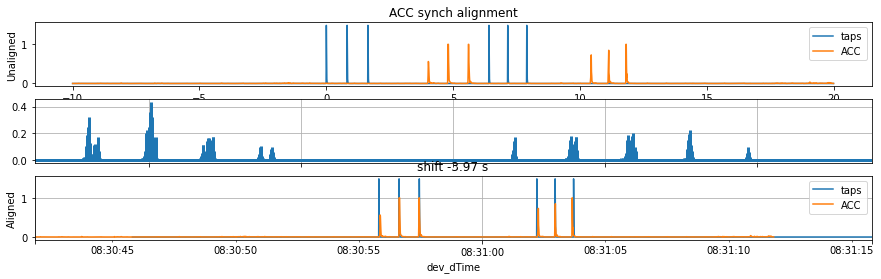

2023-02-17 08:30:55.811000+00:00


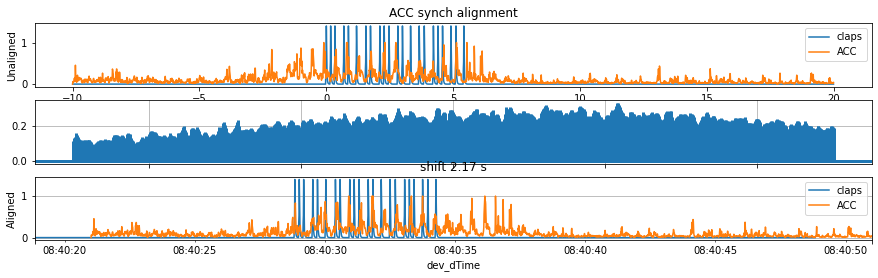

2023-02-17 08:40:28.837000+00:00


C3_Synch    2023-02-17 08:30:55.811000+00:00
C3_Reic     2023-02-17 08:40:28.837000+00:00
Name: PC706, dtype: object

In [84]:
Results = {}
cue_keys = list(synch_times.index)
for c in cue_keys:
    cue = CueT[c].copy()
    prelim_synch_time = synch_times.loc[c,'Cue_datetime']
    c_type =  synch_times.loc[c,'Cue_type']
    if sum(ACC['dev_dTime']>prelim_synch_time)>1:
        Res = al.min_align(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,5)
        Results[c] = Res
        cues_aligned.loc[pid,c] = Res['best']
        print(Res['best'])
    else:
        cues_aligned.loc[pid,c] = NODATE
cues_aligned.loc[pid,cue_keys ]

### adjust these if necessary to a better alignment

In [85]:
# first or second cue
i = 0
c=cue_keys[i]
print([c,pid])

['C3_Synch', 'PC706']


C3_Synch


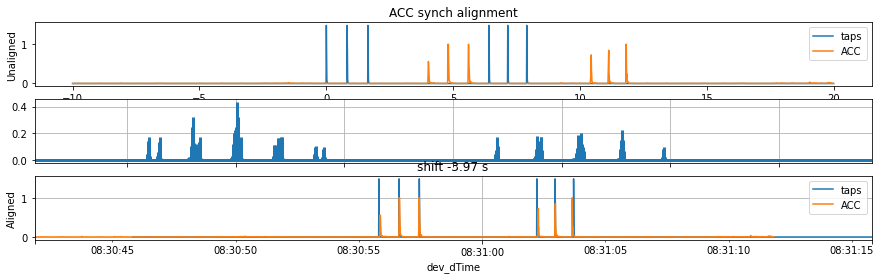

,ind,corr,shift s
0,221,0.321775,-4.79
1,298,0.226922,-4.02
2,303,0.433290,-3.97
3,936,0.200745,2.36
4,1011,0.223727,3.11


In [86]:
print(c)
shift_limits = 7 # set the range of shifts (+/-) tests. It can be up to the length used to generate the results
Res = al.min_align(ACC,CueT[c].loc[:,['sTime',synch_times.loc[c,'Cue_type']]],synch_times.loc[c,'Cue_datetime'],shift_limits)

ccthresh = 0.2
peaks = al.alt_xc_peaks(Res,ccthresh)
peaks

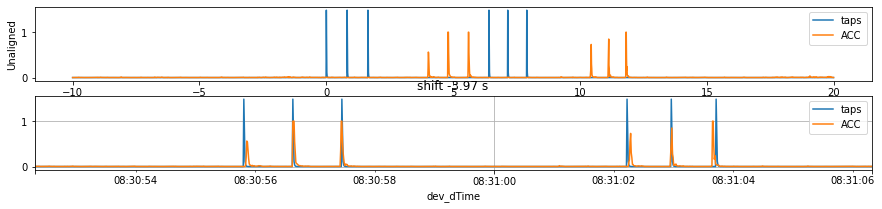

2023-02-17 08:30:55.811000+00:00


In [87]:
# specify the shift 6ou want to check by peak or enter a shift offset in seconds in test_shift
pk_int =2
shift_s = peaks.loc[pk_int,'shift s']
cues_aligned.loc[pid,c] = al.test_shift(Res,peaks.loc[pk_int,'shift s'])
print(cues_aligned.loc[pid,c])

In [540]:
# if there is no real answer here, save the unaligned version 
cues_aligned.loc[pid,c] = cue_dets.loc[c,'Cue_datetime'] #NODATE
shift_s = 0
cues_aligned

,RE_Synch,RD_Synch,RD_Reic,RD_Reic2,C1_Synch,C1_Reic,C2_Synch,C2_Reic,C3_Synch,C3_Reic,C4_Synch,C4_Reic,C5_Synch,C5_Reic
PC706,NaN,2023-02-15 11:05:35.027000+00:00,2023-02-15 11:16:50.919000+00:00,NaT,2023-02-16 08:33:19.364000+00:00,2023-02-16 08:45:22.246000+00:00,NaN,NaN,2023-02-17 08:30:55.811000+00:00,2023-02-17 08:40:28.837000+00:00,2023-02-17 10:16:30.078000+00:00,2023-02-17 10:27:21.349000+00:00,NaN,NaN
PC708,NaN,NaN,NaN,NaN,NaT,2023-02-16 08:45:25.636000+00:00,2023-02-16 10:16:27.317000+00:00,2023-02-16 10:27:15.417000+00:00,2023-02-17 08:30:52.641000+00:00,2023-02-17 08:40:25.467000+00:00,2023-02-17 10:16:25.578000+00:00,2023-02-17 10:27:23.889000+00:00,2023-02-18 15:10:29.583000+00:00,NaT


In [88]:
print([pid,concert,c,shift_s,cue_dets.loc[c,'Cue_datetime'],Show_syncs[concert]])

['PC706', 'C3', 'C3_Synch', -3.97, Timestamp('2023-02-17 08:30:51.841000+0000', tz='UTC'), Timestamp('2023-02-17 08:30:51.841000+0000', tz='UTC')]


In [489]:
cues_aligned

,RE_Synch,RD_Synch,RD_Reic,RD_Reic2,C1_Synch,C1_Reic,C2_Synch,C2_Reic,C3_Synch,C3_Reic,C4_Synch,C4_Reic,C5_Synch,C5_Reic
PC706,NaN,2023-02-15 11:05:35.027000+00:00,2023-02-15 11:16:50.919000+00:00,NaT,2023-02-16 08:33:19.364000+00:00,2023-02-16 08:45:22.246000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PC708,NaN,NaN,NaN,NaN,NaT,2023-02-16 08:45:25.636000+00:00,2023-02-16 10:16:27.317000+00:00,2023-02-16 10:27:15.417000+00:00,NaN,NaN,NaN,NaN,NaN,NaN


Must end up with a clear offset value for that recording: when the tapping cues happend or would have happend based on later cues. 

## once an offset is found 
With these move sense recordings, we can only correct for alignment, not scaling. C'est la vie.

In [89]:
row = df_files.loc[df_files['FileName']==ACC_files[fi],:].reset_index(drop=True).copy()
pid = row.loc[0,'ID']
sigFileLoc = row.loc[0,'FullLoc']
devid =  row.loc[0,'DevName']
concert #= row.loc[0,'Session']

matched_files = df_files.loc[df_files['Session'] == concert,:].copy()
matched_files = matched_files.loc[matched_files['DevName'] == devid,:].reset_index(drop = True).copy()
matched_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,FullLoc
0,RR,537,PC706,2023-02-17 07:59:13,C3,RR-PC706-537-230217075913.csv,csv,569600,2023-02-17 08:07:54.210000+00:00,2023-02-17 11:22:34.184000+00:00,11679.974,../Data/Movesense/EqForm_new/RR-PC706-537-2302...
1,FASTACC,537,PC706,2023-02-17 07:59:13,C3,FASTACC-PC706-537-230217075913.csv,csv,179820869,2023-02-17 07:59:13.646000+00:00,2023-02-17 13:16:18+00:00,19024.354,../Data/Movesense/EqForm_new/FASTACC-PC706-537...
2,ECG,537,PC706,2023-02-17 07:59:13,C3,ECG-PC706-537-230217075913.csv,csv,360399723,2023-02-17 07:59:13.462000+00:00,2023-02-17 13:16:18+00:00,19024.538,../Data/Movesense/EqForm_new/ECG-PC706-537-230...


In [90]:

outfiles = []
print(c)
for i,row in matched_files.iterrows():
    V = pd.read_csv(row['FullLoc'])
    dt_col = V.columns[0]
    sig_col = V.columns[1:]
    V[dt_col]=pd.to_datetime(V[dt_col])
    RecTimeSig = pd.DataFrame()
    RecTimeSig['c_sTime'] = np.round((V[dt_col]-Show_syncs[concert]).dt.total_seconds(),3)+ shift_s
    
    #RecTimeSig['c_sTime'] = np.round((V[dt_col]-cues_aligned.loc[pid,c]).dt.total_seconds(),3)+cue_dets.loc[c,'cTime_s'] #shift_s
    RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['c_sTime'],unit='s') + Show_syncs[concert]
    RecTimeSig['dev_dTime'] = V[dt_col]
    RecTimeSig.loc[:,sig_col] = V[sig_col]
    
    new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
    
    cuts = Show_intervals[concert]
    subsig  = al.dt_cut(RecTimeSig,'rec_dTime',cuts[0],cuts[1])
    seg_filename = concert + '_FULL_' + row['ID'] + '_' + eq_sigs[row['Signal']] + '.csv'
    outfiles.append(seg_filename)
    subsig[new_col_order].to_csv(Show_folder[concert] + seg_filename, index = False)

outfiles

C3_Synch


['C3_FULL_PC706_MSCIBI.csv',
 'C3_FULL_PC706_MSBACC.csv',
 'C3_FULL_PC706_MS1ECG.csv']